##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 映画レビューのテキスト分類

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/ja/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/ja/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

ここでは、映画のレビューをそのテキストを使って**肯定的**か**否定的**かに分類します。これは、二値分類あるいは2クラス分類という問題の例であり、機械学習において重要でいろいろな応用が可能なものです。

ここでは、[Internet Movie Database](https://www.imdb.com/)から抽出した50,000件の映画レビューを含む、 [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) を使います。レビューは訓練用とテスト用に25,000件ずつに分割されています。訓練用とテスト用のデータは**均衡**しています。言い換えると、それぞれが同数の肯定的及び否定的なレビューを含んでいます。

ここでは、TensorFlowを使ってモデルを構築・訓練するためのハイレベルなAPIである [tf.keras](https://www.tensorflow.org/guide/keras)を使用します。`tf.keras`を使ったもう少し高度なテキスト分類のチュートリアルについては、 [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/)を参照してください。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1


## IMDB datasetのダウンロード

IMDBデータセットは、TensorFlowにパッケージ化されています。それは前処理済みのものであり、（単語の連なりである）レビューが、整数の配列に変換されています。そこでは整数が辞書中の特定の単語を表します。

次のコードは、IMDBデータセットをあなたのパソコンにダウンロードします。（すでにダウンロードしていれば、キャッシュされたコピーを使用します）

In [2]:
from functools import partial
import numpy as np
np.load = partial(np.load, allow_pickle=True)

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

`num_words=10000`という引数は、訓練データ中に出てくる単語のうち、最も頻繁に出現する10,000個を保持するためのものです。データサイズを管理可能にするため、稀にしか出現しない単語は破棄されます。

## データを調べる

データの形式を理解するために少し時間を割いてみましょう。このデータセットは前処理済みで、サンプルそれぞれが、映画レビューの中の単語を表す整数の配列になっています。ラベルはそれぞれ、0または1の整数値で、0が否定的レビュー、1が肯定的なレビューを示しています。

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


レビューのテキストは複数の整数に変換されており、それぞれの整数が辞書の中の特定の単語を表します。最初のレビューがどのようなものか見てみましょう。

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


映画のレビューはそれぞれ長さが異なっていることでしょう。次のコードで、最初と2つ目のレビューの単語の数を見てみます。ニューラルネットワークへの入力は同じ長さでなければならないため、後ほどその問題を解決する必要があります。

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 整数を単語に戻してみる

整数をテキストに戻す方法を知っていると便利です。整数を文字列にマッピングする辞書オブジェクトを検索するためのヘルパー関数を定義します。

In [6]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


`decode_review`を使うと、最初のレビューのテキストを表示できます。

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## データの準備

レビュー（整数の配列）は、ニューラルネットワークに投入する前に、テンソルに変換する必要があります。これには2つの方法があります。

* 配列をワンホット（one-hot）エンコーディングと同じように、単語の出現を表す0と1のベクトルに変換します。例えば、[3, 5]という配列は、インデックス3と5を除いてすべてゼロの10,000次元のベクトルになります。そして、これをネットワークの最初の層、すなわち、浮動小数点のベクトルデータを扱うことができるDense（全結合）層とします。ただし、これは単語数×レビュー数の行列が必要なメモリ集約的な方法です。
* もう一つの方法では、配列をパディングによって同じ長さに揃え、`サンプル数 * 長さの最大値`の形の整数テンソルにします。そして、この形式を扱うことができるEmbedding（埋め込み）層をネットワークの最初の層にします。

このチュートリアルでは、後者を採用することにします。

映画レビューは同じ長さでなければならないので、長さを標準化する [pad_sequences](https://www.tensorflow.org/versions/r1.10/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 関数を使うことにします。

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

サンプルの長さを見てみましょう。

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

次に、パディング済みの最初のサンプルを確認します。

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## モデルの構築

ニューラルネットワークは、層を積み重ねることで構成されます。この際、２つの大きな決定が必要です。

* モデルにいくつの**層**を設けるか？
* 層ごとに何個の**隠れユニット**を使用するか？

この例では、入力データは単語インデックスの配列で構成されています。推定の対象となるラベルは、0または1です。この問題のためのモデルを構築しましょう。

In [11]:
# 入力の形式は映画レビューで使われている語彙数（10,000語）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


これらの層は、分類器を構成するため一列に積み重ねられます。

1. 最初の層は`Embedding`（埋め込み）層です。この層は、整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索します。埋め込みベクトルは、モデルの訓練の中で学習されます。ベクトル化のために、出力行列には次元が１つ追加されます。その結果、次元は、`(batch, sequence, embedding)`となります。
2. 次は、`GlobalAveragePooling1D`（１次元のグローバル平均プーリング）層です。この層は、それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返します。この結果、モデルは最も単純な形で、可変長の入力を扱うことができるようになります。
3. この固定長の出力ベクトルは、16個の隠れユニットを持つ全結合（`Dense`）層に受け渡されます。
4. 最後の層は、1個の出力ノードに全結合されます。シグモイド（`sigmoid`）活性化関数を使うことで、値は確率あるいは確信度を表す0と1の間の浮動小数点数となります。

### 隠れユニット

上記のモデルには、入力と出力の間に、2つの中間層あるいは「隠れ」層があります。出力（ユニット、ノード、またはニューロン）は、その層の内部表現の次元数です。言い換えると、このネットワークが学習によって内部表現を獲得する際の自由度ということです。

モデルにより多くの隠れユニットがある場合（内部表現空間の次元数がより大きい場合）、または、より多くの層がある場合、あるいはその両方の場合、ネットワークはより複雑な内部表現を学習することができます。しかしながら、その結果として、ネットワークの計算量が多くなるほか、学習してほしくないパターンを学習するようになります。学習してほしくないパターンとは、訓練データでの性能は向上するものの、テスト用データの性能が向上しないパターンです。この問題を**過学習**（*overfitting*）といいます。この問題は後ほど検証することになります。

### 損失関数とオプティマイザ

モデルを訓練するには、損失関数とオプティマイザが必要です。今回の問題は二値分類問題であり、モデルの出力は確率（1ユニットの層とシグモイド活性化関数）であるため、損失関数として`binary_crossentropy`（2値のクロスエントロピー）関数を使用することにします。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

後ほど、回帰問題を検証する際には（例えば家屋の値段を推定するとか）、もう一つの損失関数である`mean_squared_error`（平均二乗誤差）の使い方を目にすることになります。

さて、モデルのオプティマイザと損失関数を設定しましょう。

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 検証用データを作る

訓練を行う際、モデルが見ていないデータでの正解率を検証したいと思います。もとの訓練用データから、10,000個のサンプルを取り分けて**検証用データ**（*validation set*）を作ります。（なぜ、ここでテスト用データを使わないのでしょう？ 今回の目的は、訓練用データだけを使って、モデルの開発とチューニングを行うことです。その後、テスト用データを1回だけ使い、正解率を検証するのです。）

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## モデルの訓練

512個のサンプルからなるミニバッチを使って、40エポックモデルを訓練します。この結果、`x_train`と`y_train`に含まれるすべてのサンプルを40回繰り返すことになります。訓練中、検証用データの10,000サンプルを用いて、モデルの損失と正解率をモニタリングします。

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 92us/sample - loss: 0.6922 - acc: 0.5116 - val_loss: 0.6909 - val_acc: 0.5283
Epoch 2/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.6880 - acc: 0.6180 - val_loss: 0.6848 - val_acc: 0.6291
Epoch 3/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6776 - acc: 0.6846 - val_loss: 0.6712 - val_acc: 0.7245
Epoch 4/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6582 - acc: 0.7245 - val_loss: 0.6486 - val_acc: 0.7557
Epoch 5/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6285 - acc: 0.7716 - val_loss: 0.6173 - val_acc: 0.7756
Epoch 6/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.5900 - acc: 0.8011 - val_loss: 0.5800 - val_acc: 0.7899
Epoch 7/40
15000/15000 [==============================] - 1s 49us/sa

## モデルの評価

さて、モデルの性能を見てみましょう。2つの値が返されます。損失（エラーを示す数値であり、小さい方が良い）と正解率です。

In [15]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 24us/sample - loss: 0.3231 - acc: 0.8726
[0.3231329037475586, 0.8726]


この、かなり素朴なアプローチでも87%前後の正解率を達成しました。もっと高度なアプローチを使えば、モデルの正解率は95%に近づけることもできるでしょう。

## 正解率と損失の時系列グラフを描く

`model.fit()` は、訓練中に発生したすべてのことを記録した辞書を含む`History` オブジェクトを返します。

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

4つのエントリがあります。それぞれが、訓練と検証の際にモニターしていた指標を示します。これを使って、訓練時と検証時の損失を比較するグラフと、訓練時と検証時の正解率を比較するグラフを作成することができます。

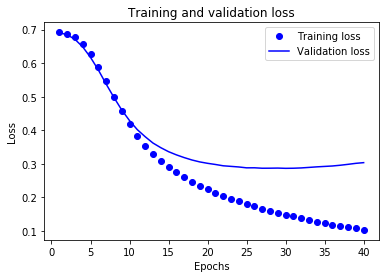

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" は青いドット
plt.plot(epochs, loss, 'bo', label='Training loss')
# ”b" は青い実線
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

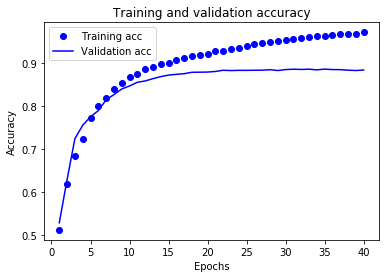

In [18]:
plt.clf()   # 図のクリア
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

上記のグラフでは、点が訓練時の損失と正解率を、実線が検証時の損失と正解率を表しています。

訓練時の損失がエポックごとに**減少**し、訓練時の正解率がエポックごとに**上昇**していることに気がつくはずです。繰り返すごとに指定された数値指標を最小化する勾配降下法を最適化に使用している場合に期待される動きです。

これは、検証時の損失と正解率には当てはまりません。20エポックを過ぎたあたりから、横ばいになっているようです。これが、過学習の一例です。モデルの性能が、訓練用データでは高い一方で、見たことの無いデータではそれほど高くないというものです。このポイントをすぎると、モデルが最適化しすぎて、訓練用データでは特徴的であるが、テスト用データには一般化できない内部表現を学習しています。

このケースの場合、20エポックを過ぎたあたりで訓練をやめることで、過学習を防止することが出来ます。後ほど、コールバックを使って、これを自動化する方法を紹介します。